In [2]:
import sys
import os
import vamb4
import numpy as np
import importlib
from vamb4 import graph
import torch as _torch
from torch.nn.functional import cosine_similarity
import matplotlib.pyplot as plt
import latent_visual
import json

## generate plot for ptracker dataset

In [3]:
# load identifier and graph_dict
dataset = 'oral'
composition = vamb4.parsecontigs.Composition.load('/Users/liuxinyuan/Desktop/master_thesis/new_graph/spades/{}/vambout/composition.npz'.format(dataset))
abundance = vamb4.parsebam.Abundance.load("/Users/liuxinyuan/Desktop/master_thesis/new_graph/spades/{}/vambout/abundance.npz".format(dataset), composition.metadata.refhash)
identifiers = list(composition.metadata.identifiers)
graph_dict = vamb4.graph.neighbors_dict_new('/Users/liuxinyuan/Desktop/master_thesis/week9/new_assebgraph/{}/neighbours_dg_5.txt'.format(dataset),list(identifiers))

In [4]:
# load genome_contigs_dict
with open('genome_contigs_oral_pt.json','r') as f:
    genome_contigs_dict = json.load(f)

In [5]:
# create genome list, contigs list and depend list
genomes = []
with open('/Users/liuxinyuan/Desktop/master_thesis/week8/selected_genomes.txt','r') as file:
    for line in file:
        parts = line.strip().split('\t')
        genomes.append(parts[1])
genomes_type = set(genomes)
contigs_list = []
genomes_list = []
for genome in genomes_type:
    contigs_list += genome_contigs_dict[genome]
    genomes_list += [genome] * len(genome_contigs_dict[genome])
depend_list = [1 if len(graph_dict[contig])>1 else 0 for contig in contigs_list]

In [2]:
# load latent file
# weight = 0.1
matrix_sage_sage = _torch.load('/Users/liuxinyuan/Desktop/master_thesis/week9/errorfree/thesis_ef/sage_sage/train_latent_oral_0510_200_0.1.npz')
latent_sage_sage = vamb4.cluster._normalize(matrix_sage_sage)
# matrix_ori = _torch.load('/Users/liuxinyuan/Desktop/master_thesis/week9/original/oral/latent_oral_0429_ori.npz')
# latent_ori = vamb4.cluster._normalize(matrix_ori)
matrix_lin_cos = _torch.load('/Users/liuxinyuan/Desktop/master_thesis/week9/errorfree/thesis_ef/lin_cos/train_latent_oral_0510_200_0.1.npz')
latent_lin_cos = vamb4.cluster._normalize(matrix_lin_cos)

In [22]:
def plot_latent(latent: _torch.Tensor,
                depend_check_: list, # A list to check if the contig in ploted contigs is dependent
                contigs_list_: list, # A list of contigs' index which are choosen to be ploted
                genomes_list_: list, # A list of genomes which are choosen to be ploted
                model_name: str,
                dimensions: list=[0,1], # The choosen dimensions to be ploted, default is first two
                ):
    genome_cat_nodup = list(set(genomes_list_))
    colors = list([plt.cm.tab10(i) for i in range(len(genome_cat_nodup))])
    colors_all = []
    for cat in genomes_list_:
        color_index = genome_cat_nodup.index(cat)
        colors_all.append(colors[color_index])
    depend_colors = [colors_all[i] for i,_ in enumerate(contigs_list_) if depend_check_[i]==1]
    independ_colors = [colors_all[i] for i,_ in enumerate(contigs_list_) if depend_check_[i]==0]
    depend_check_ = np.array(depend_check_)
    plt.figure(figsize=(15,4.5))
    epoch_list = [1,150,300]
    for i in range(3):
        normed_latent = vamb4.cluster._normalize(latent[i])
        plt.subplot(1,3,i+1)
        x = normed_latent[contigs_list_,dimensions[0]].numpy()
        y = normed_latent[contigs_list_,dimensions[1]].numpy()
        plt.scatter(x[depend_check_==0], y[depend_check_==0], edgecolors=independ_colors,facecolors='none',alpha=0.8,label='nnei=0')
        plt.scatter(x[depend_check_==1], y[depend_check_==1], c=depend_colors,alpha=0.8,label = 'nnei>0')
        # plt.xlim((-4,4))
        # plt.ylim((-4,4))
        # plt.title('epoch {}'.format(epoch_list[i]))
        if i==0:
            plt.ylabel('{}'.format(model_name),fontdict={'fontsize':19})
    
    plt.legend()


In [7]:
def plot_latent_depend(latent: _torch.Tensor,
                depend_check_: list, # A list to check if the contig in ploted contigs is dependent
                contigs_list_: list, # A list of contigs' index which are choosen to be ploted
                genomes_list_: list, # A list of genomes which are choosen to be ploted
                model_name: str,
                dimensions, # The choosen dimensions to be ploted, default is first two
                ):
    genome_cat_nodup = list(set(genomes_list_))
    colors = list([plt.cm.tab10(i) for i in range(len(genome_cat_nodup))])
    colors_all = []
    for cat in genomes_list_:
        color_index = genome_cat_nodup.index(cat)
        colors_all.append(colors[color_index])
    depend_colors = [colors_all[i] for i,_ in enumerate(contigs_list_) if depend_check_[i]==1]
    independ_colors = [colors_all[i] for i,_ in enumerate(contigs_list_) if depend_check_[i]==0]
    depend_check_ = np.array(depend_check_)
    x = latent[contigs_list_,dimensions[0]].numpy()
    y = latent[contigs_list_,dimensions[1]].numpy()

    # plt.scatter(x[depend_check_==0], y[depend_check_==0], edgecolors=independ_colors,facecolors='none',alpha=0.8,label='nnei=0')
    plt.scatter(x[depend_check_==1], y[depend_check_==1], c=depend_colors,alpha=0.8,label = 'nnei>0')
    plt.legend()
    # plt.title('{}'.format(model_name))

In [8]:
def plot_latent_independ(latent: _torch.Tensor,
                depend_check_: list, # A list to check if the contig in ploted contigs is dependent
                contigs_list_: list, # A list of contigs' index which are choosen to be ploted
                genomes_list_: list, # A list of genomes which are choosen to be ploted
                model_name: str,
                dimensions, # The choosen dimensions to be ploted, default is first two
                ):
    genome_cat_nodup = list(set(genomes_list_))
    colors = list([plt.cm.tab10(i) for i in range(len(genome_cat_nodup))])
    colors_all = []
    for cat in genomes_list_:
        color_index = genome_cat_nodup.index(cat)
        colors_all.append(colors[color_index])
    depend_colors = [colors_all[i] for i,_ in enumerate(contigs_list_) if depend_check_[i]==1]
    independ_colors = [colors_all[i] for i,_ in enumerate(contigs_list_) if depend_check_[i]==0]
    depend_check_ = np.array(depend_check_)
    x = latent[contigs_list_,dimensions[0]].numpy()
    y = latent[contigs_list_,dimensions[1]].numpy()

    plt.scatter(x[depend_check_==0], y[depend_check_==0], edgecolors=independ_colors,facecolors='none',alpha=0.8,label='nnei=0')
    # plt.scatter(x[depend_check_==1], y[depend_check_==1], c=depend_colors,alpha=0.8,label = 'nnei>0')
    plt.legend()
    # plt.title('{}'.format(model_name))

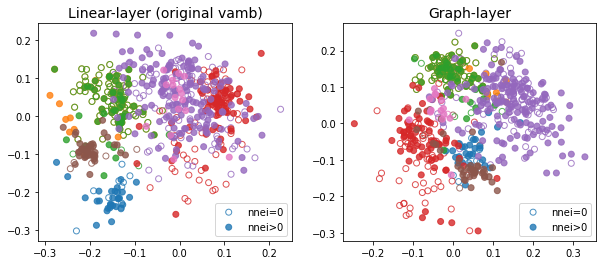

In [22]:
dataset = 'oral'
matrix_sage = _torch.load('sage_nodist/graph/{}/latent_{}_0506.npz'.format(dataset,dataset))
latent_sage = vamb4.cluster._normalize(matrix_sage)
matrix_ori = _torch.load('original/{}/latent_{}_0502_ori.npz'.format(dataset,dataset))
latent_ori = vamb4.cluster._normalize(matrix_ori)
dimensions = [0,1]
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plot_latent(latent_ori,depend_list,contigs_list,genomes_list,'Linear-layer (original vamb)',dimensions)
plt.subplot(1,2,2)
plot_latent(-latent_sage,depend_list,contigs_list,genomes_list,'Graph-layer',dimensions)
plt.savefig('graphvamb_plot/ori_sagenodict_scatter.png',dpi=300)

## generate plot for errorfree dataset

In [3]:
# load identifier and graph_dict
importlib.reload(vamb4.graph)
dataset = 'oral'
composition = vamb4.parsecontigs.Composition.load('/Users/liuxinyuan/Desktop/master_thesis/data/oral/errorfree/vambout/composition.npz')
abundance = vamb4.parsebam.Abundance.load("/Users/liuxinyuan/Desktop/master_thesis/data/oral/errorfree/vambout/abundance.npz", composition.metadata.refhash)
identifiers = list(composition.metadata.identifiers)
graph_dict = vamb4.graph.neighbors_dict('/Users/liuxinyuan/Desktop/master_thesis/week9/new_assebgraph/oral/neighbours_dg_10_only_TPs.txt',list(identifiers))

In [4]:
# load genome_contigs_dict
with open('genome_contigs_oral_dict.json','r') as f:
    genome_contigs_dict = json.load(f)
with open('contig_genomes_oral_ef.json','r') as f:
    contig_genomes_dict = json.load(f)
genome_contigs_only1 = {}
for genome, contigs in genome_contigs_dict.items():
    genome_contigs_only1[genome] = [contig for contig in contigs if len(contig_genomes_dict[str(contig)])==1]

In [5]:
select_genomes = []
for genome,contigs in genome_contigs_only1.items():
    if len(contigs)>0:
        n_dp_contigs = 0
        n_idp_contigs = 0
        for contig in contigs:
            if len(graph_dict[contig]) > 1:
                n_dp_contigs +=1
            else:
                n_idp_contigs += 1
        dp_contigs_ratio = n_dp_contigs/len(contigs)
        if dp_contigs_ratio > 0.5 and len(contigs)>40:
            select_genomes.append(genome) 
        if len(select_genomes)>=6:
            break

genomes_type = select_genomes
contigs_list = []
genomes_list = []
for genome in genomes_type:
    contigs_list += genome_contigs_only1[genome]
    genomes_list += [genome] * len(genome_contigs_only1[genome])
depend_list = [1 if len(graph_dict[contig])>1 else 0 for contig in contigs_list]
len(select_genomes),len(contigs_list)

(4, 787)

In [6]:
select_genomes

['OTU_97.20.0', 'OTU_97.27797.0', 'OTU_97.429.0', 'OTU_97.31969.0']

In [7]:
train_sage_sage = _torch.load('/Users/liuxinyuan/Desktop/master_thesis/week9/errorfree/thesis_ef/sage_sage/train_latent_oral_0510_200_0.1.npz',map_location=_torch.device('cpu') )
train_lin_cos = _torch.load('/Users/liuxinyuan/Desktop/master_thesis/week9/errorfree/thesis_ef/lin_cos/train_latent_oral_0510_200_0.1.npz',map_location=_torch.device('cpu'))
train_lin_sage = _torch.load('/Users/liuxinyuan/Desktop/master_thesis/week9/errorfree/thesis_ef/lin_sage/train_latent_oral_0510_200_0.1.npz',map_location=_torch.device('cpu'))
train_sage_cos = _torch.load('/Users/liuxinyuan/Desktop/master_thesis/week9/errorfree/thesis_ef/sage_cos/train_latent_oral_0510_200_0.1.npz',map_location=_torch.device('cpu'))
train_ori = _torch.load('/Users/liuxinyuan/Desktop/master_thesis/week9/errorfree/thesis_ef/ori/train_latent_oral_0510ori_200_0.npz',map_location=_torch.device('cpu'))
train_sage_no = _torch.load('/Users/liuxinyuan/Desktop/master_thesis/week9/errorfree/thesis_ef/sage_no/train_latent_oral_0510_200_0.npz',map_location=_torch.device('cpu'))


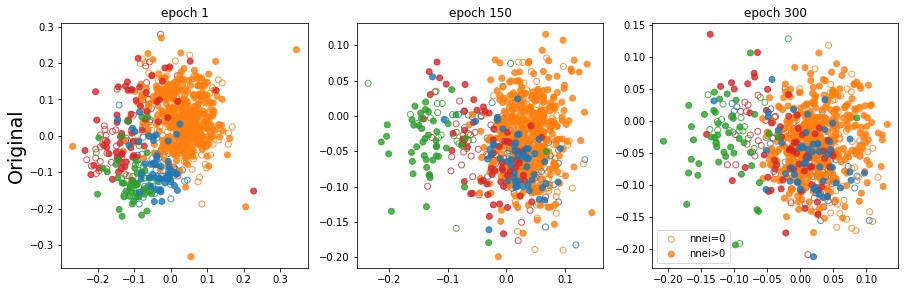

In [17]:
plot_latent(train_ori,depend_list,contigs_list,genomes_list,'Original',[1,0])
plt.savefig('graphvamb_plot/scatter_ori.png',dpi=300)


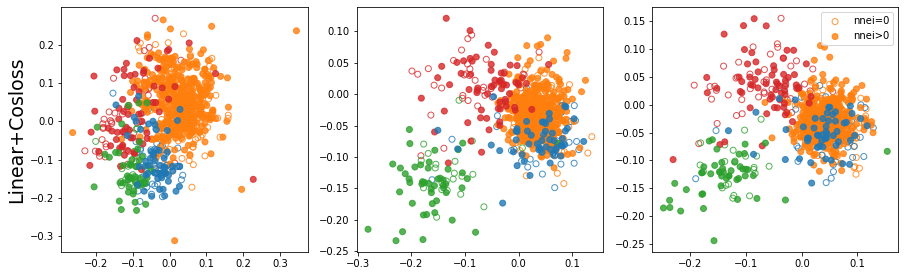

In [19]:
plot_latent(train_lin_cos,depend_list,contigs_list,genomes_list,'Linear+Cosloss',[1,0])
plt.savefig('graphvamb_plot/scatter_lin_cos.png',dpi=300)

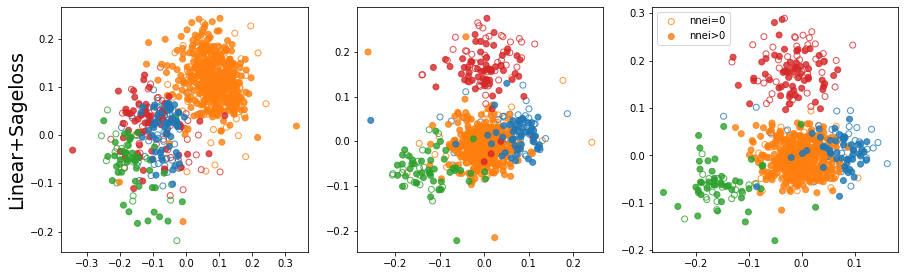

In [21]:
plot_latent(train_lin_sage,depend_list,contigs_list,genomes_list,'Linear+Sageloss',[0,1])
plt.savefig('graphvamb_plot/scatter_lin_sage.png',dpi=300)


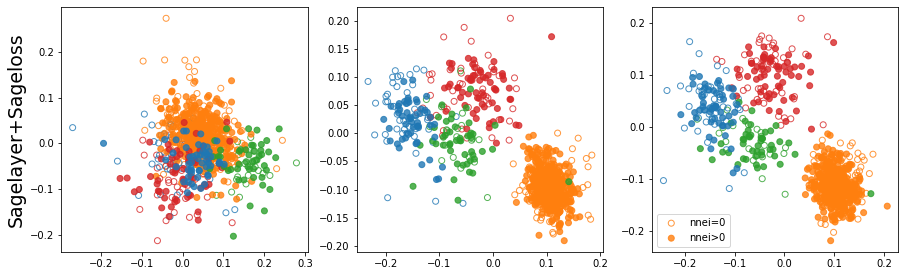

In [23]:
plot_latent(train_sage_sage,depend_list,contigs_list,genomes_list,'Sagelayer+Sageloss',[0,1])
plt.savefig('graphvamb_plot/scatter_sage_sage.png',dpi=300)

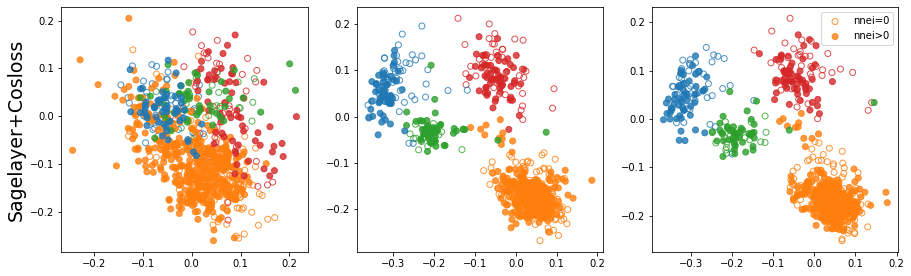

In [24]:
plot_latent(train_sage_cos,depend_list,contigs_list,genomes_list,'Sagelayer+Cosloss',[0,1])
plt.savefig('graphvamb_plot/scatter_sage_cos.png',dpi=300)

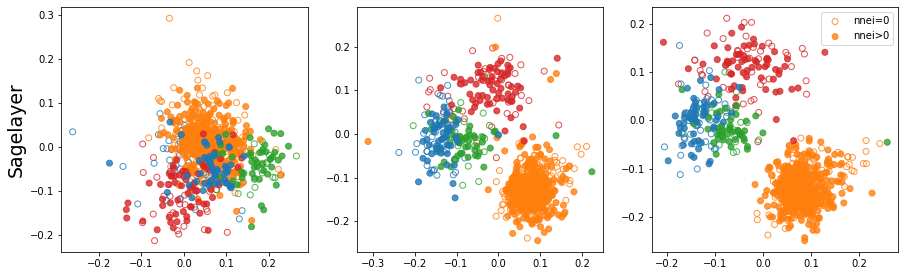

In [25]:
plot_latent(train_sage_no,depend_list,contigs_list,genomes_list,'Sagelayer',[0,1])
plt.savefig('graphvamb_plot/sagelayer.png',dpi=300)